In [1]:
#Import Modules
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.helpers import write_geotiff

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import TasseledCapTools

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

In [2]:
help(write_geotiff)

Help on function write_geotiff in module datacube.helpers:

write_geotiff(filename, dataset, profile_override=None, time_index=None)
    Write an ODC style xarray.Dataset to a GeoTIFF file.
    
    :param filename: Output filename
    :param dataset: xarray dataset containing one or more bands to write to a file.
    :param profile_override: option dict, overrides rasterio file creation options.
    :param time_index: DEPRECATED



In [3]:
#define area of interest
query = {
    
        #Tanbar QLD
# 'y': (-26.141, -26.269),
# 'x': (141.482, 141.669), 
    
    #Pambula wetlands
'y': (-36.924, -36.988),
'x': (149.848, 149.925), 
    
# #ever lasting swamp
# 'y': (-29.365, -29.489),
# 'x': (153.033, 153.200),
    
    
#lake Coleman
# 'y': (-38.103, -38.259),
# 'x': (147.098, 147.421),

         #Macquarie Marshes
# 'y': (-30.512, -30.977),
# 'x': (147.413, 147.809),
    
#     #Daintree Rainforrest
# 'y': (-16.140, -16.209),
# 'x': (145.394, 145.460),    

    
    #Big Gunbower
# 'y': (-35.636, -35.905),
# 'x': (144.102, 144.387),
    
# jerrabombera wetland
#'y': (-35.288, -35.346),
#'x': (149.139, 149.191),

#ACT
# 'y': (-35.270, -35.336),
# 'x': (149.021, 149.194),    

    #lake george
# 'y': (-34.957, -35.221),
# 'x': (149.294, 149.519),   
    
#Kowen
# 'y': (-35.269, -35.354),
# 'x': (149.239, 149.396),   
    
#gunbower
# 'y': (-35.743, -35.909),
# 'x': (144.235, 144.387),
    
    
'time': ('2018-01-01', '2018-12-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [4]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8

<xarray.Dataset>
Dimensions:          (time: 46, x: 313, y: 320)
Coordinates:
  * time             (time) datetime64[ns] 2018-01-03T23:45:03 ... 2018-12-28T23:50:34
  * y                (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x                (x) float64 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    coastal_aerosol  (time, y, x) int16 251 294 327 321 ... 8800 8708 8677 8537
    blue             (time, y, x) int16 175 222 245 239 ... 8347 8275 8217 8092
    green            (time, y, x) int16 297 327 340 304 ... 8534 8298 8279 8207
    red              (time, y, x) int16 190 225 258 261 ... 8537 8346 8359 8203
    nir              (time, y, x) int16 2713 2529 2356 2074 ... 8537 8507 8331
    swir1            (time, y, x) int16 1002 1167 1232 1054 ... 3763 3775 3912
    swir2            (time, y, x) int16 454 483 552 497 ... 3138 2899 3007 3098
Attributes:
    crs:      EPSG: 3577

In [5]:
#define number of total observations

total_obs = int(len(data_lst8.time))
total_obs

46

In [6]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 46, x: 313, y: 320)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-03T23:45:03 ... 2018-12-28T23:50:34
  * y             (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x             (x) float64 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 16383 ... 12799 12799 12799
Attributes:
    crs:      EPSG: 3577

In [7]:
# #load wofs filtered summary
wofs_filtered_summary= dc.load(product = 'wofs_annual_summary', **query)
wofs_filtered_summary

<xarray.Dataset>
Dimensions:      (time: 1, x: 313, y: 320)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01
  * y            (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x            (x) float64 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 ... 26 27 27 27 27 27 28 28
    count_clear  (time, y, x) int16 18 14 0 0 0 16 18 ... 27 27 27 28 28 28 28
    frequency    (time, y, x) float32 0.0 0.0 -1.0 -1.0 ... 0.96428573 1.0 1.0
Attributes:
    crs:      EPSG: 3577

In [8]:
#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality

<xarray.DataArray 'pixelquality' (time: 46, y: 320, x: 313)>
array([[[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True, False, ...,  True,  True],
        [ True, False, ..., False, False],
        ...,
        [False, False, ...,  True, False],
        [False, False, ...,  True,  True]],

       ...,

       [[ True,  True, ..., False, False],
        [ True,  True, ..., False, False],
        ...,
        [False, False, ..., False,  True],
        [False, False, ...,  True,  True]],

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-03T23:45:03 ... 2018-12-28T23:50:34
  * y        (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x        

In [9]:
#apply Mask
Masked_lst8_data = data_lst8.where(good_quality)


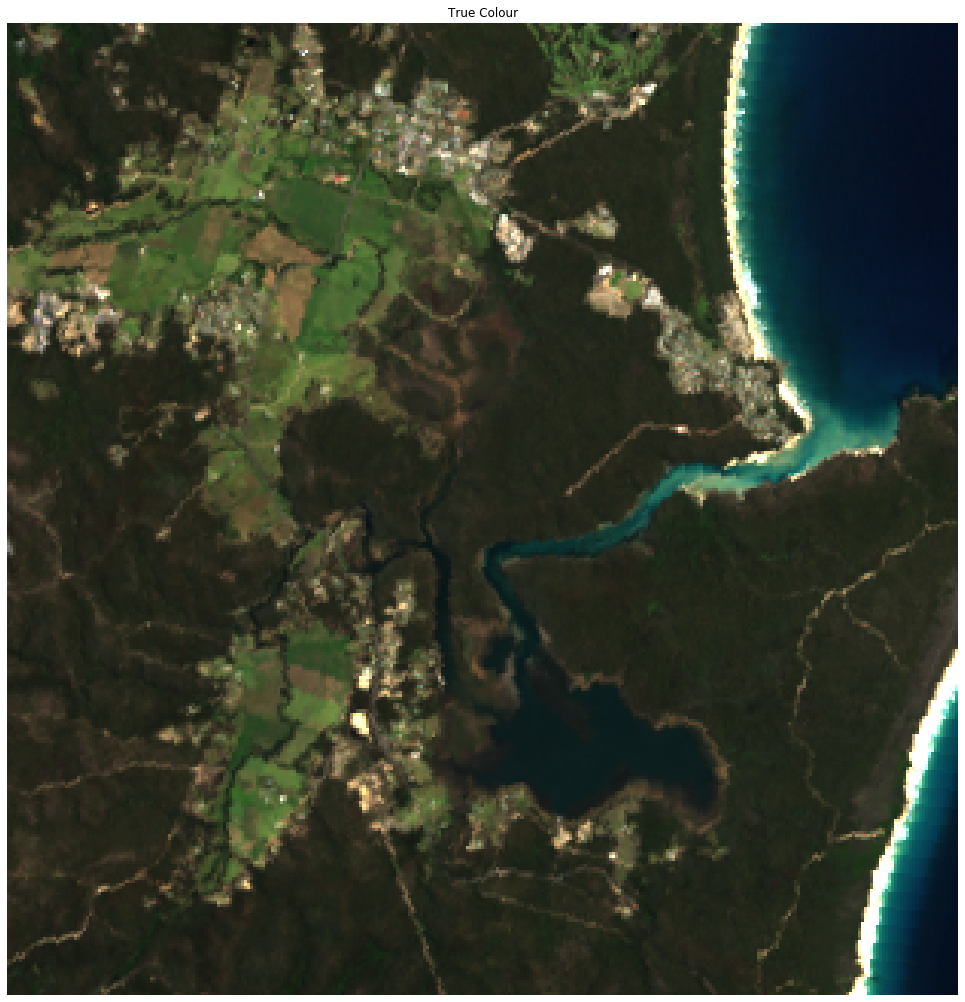

In [11]:
data_lst8_once = Masked_lst8_data.isel(time=4)

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

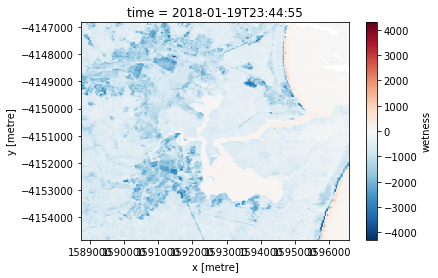

In [11]:
#Do tassled Cap transformation
TCI = TasseledCapTools.thresholded_tasseled_cap(Masked_lst8_data,wetness_threshold=-1200, drop=True
                                                , drop_tc_bands=False)
tcw = TCI['wetness']
tcg = TCI['greenness']
tcb = TCI['brightness']

tcw.isel(time=2).plot()

In [12]:
#Apply wet classification over Data

wet_values = tcw.where(tcw<-350, 1) #first turn everything wet to 1
wet_values = wet_values.where(tcw>=-350,0) #then turn everything dry to 0

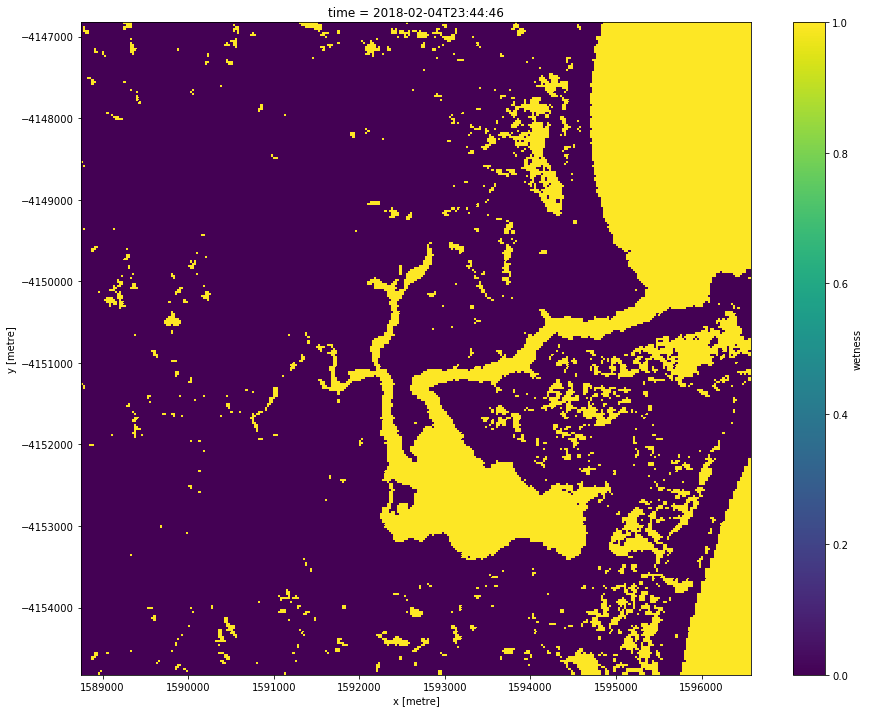

In [13]:
wet_values.isel(time=4).plot(figsize =(15,12))

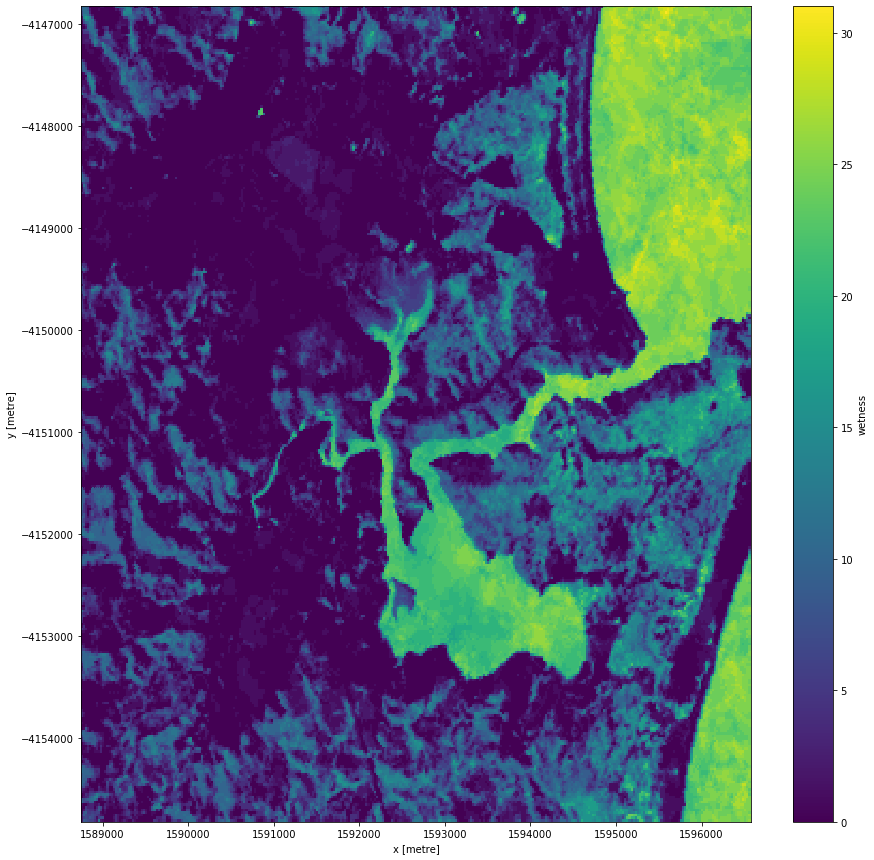

In [14]:
#Combine all date slices to gether to create a wetness frequency

wet_frequency = wet_values.sum(dim='time')
wet_frequency.plot(figsize =(15,15))

In [15]:
#Calulate what number of wetness observations is equal to X% of total observations

precent_threhold = total_obs*0.05
precent_threhold

2.3000000000000003

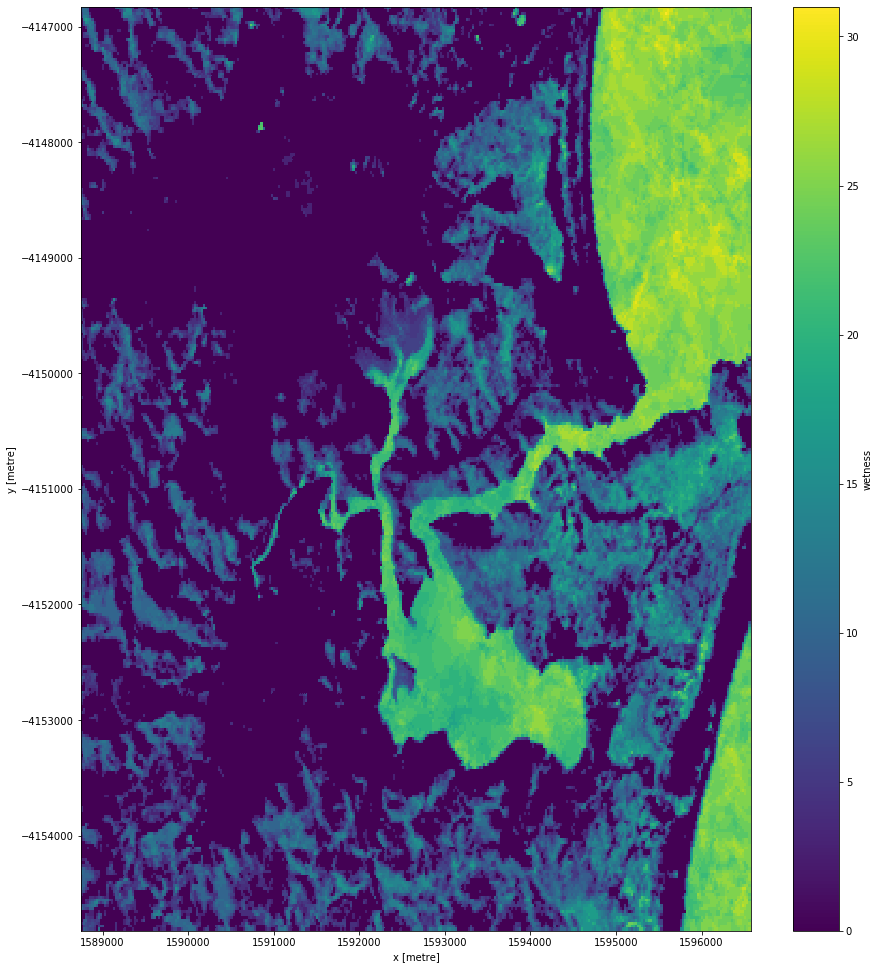

In [16]:
#apply X% threshold to find area inundated for X amount of time

persistant_wet = wet_frequency.where(wet_frequency>precent_threhold,0)

persistant_wet.plot(figsize =(15,17))

In [17]:

# #load wofs filtered summary
wofs_filtered_summary= dc.load(product = 'wofs_annual_summary', **query)
wofs_filtered_summary

<xarray.Dataset>
Dimensions:      (time: 1, x: 313, y: 320)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01
  * y            (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x            (x) float64 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 ... 26 27 27 27 27 27 28 28
    count_clear  (time, y, x) int16 18 14 0 0 0 16 18 ... 27 27 27 28 28 28 28
    frequency    (time, y, x) float32 0.0 0.0 -1.0 -1.0 ... 0.96428573 1.0 1.0
Attributes:
    crs:      EPSG: 3577

In [18]:
wofs_water = wofs_filtered_summary['count_wet']
wofs_water

<xarray.DataArray 'count_wet' (time: 1, y: 320, x: 313)>
array([[[ 0,  0, ..., 23, 23],
        [ 0,  0, ..., 22, 22],
        ...,
        [ 0,  0, ..., 28, 27],
        [ 0,  0, ..., 28, 28]]], dtype=int16)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01
  * y        (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x        (x) float64 1.589e+06 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Attributes:
    units:    1
    nodata:   -1
    crs:      EPSG: 3577

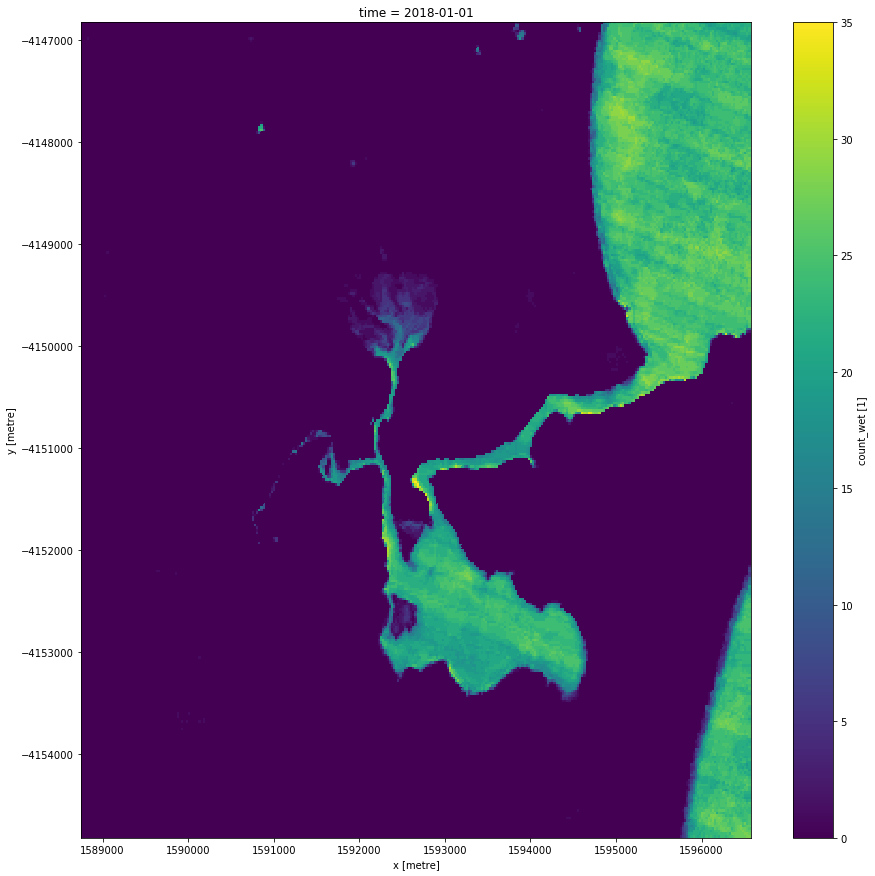

In [19]:
wofs_water.plot(figsize =(15,15))

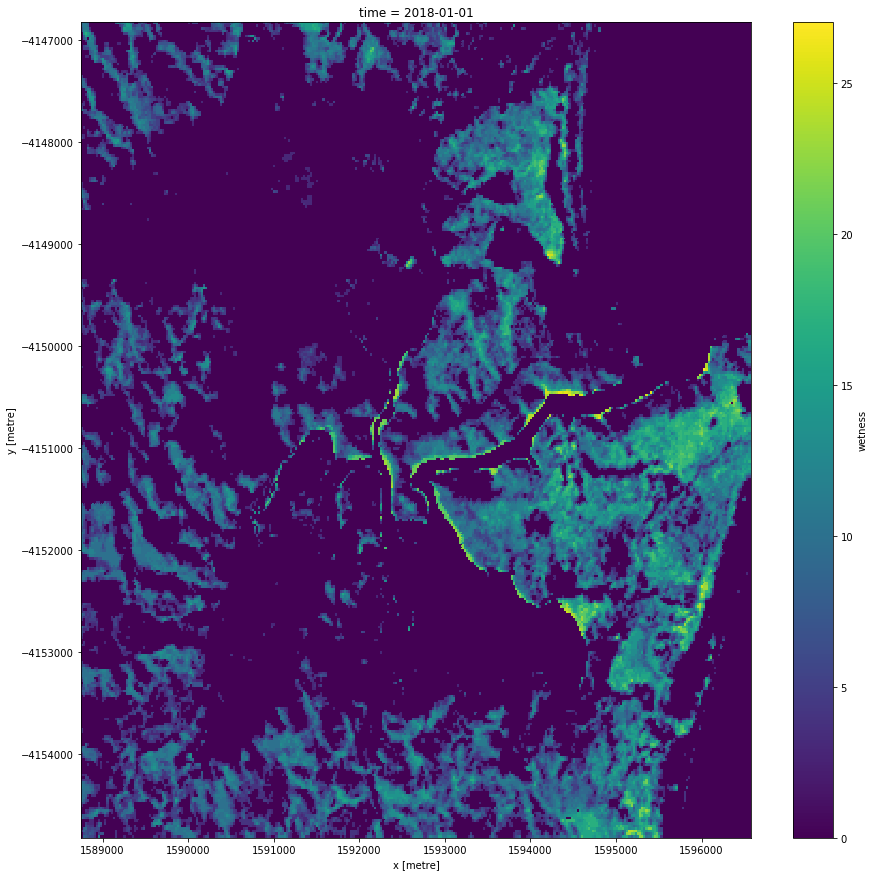

In [20]:
Inundated_veg = persistant_wet.where(wofs_water<1,0)
Inundated_veg.plot(figsize =(15,15))

In [21]:
# persistant_wet = persistant_wet.where(persistant_wet<=0,1)

In [22]:
# persistant_wet.plot(figsize =(15,15))

In [23]:
persistant_wet

<xarray.DataArray 'wetness' (y: 320, x: 313)>
array([[10., 10., 10., ..., 24., 25., 26.],
       [ 9., 11., 11., ..., 24., 24., 24.],
       [ 7., 11., 11., ..., 25., 24., 24.],
       ...,
       [ 3.,  9.,  7., ..., 25., 25., 26.],
       [ 0.,  6.,  7., ..., 24., 25., 25.],
       [ 0.,  9.,  8., ..., 24., 25., 26.]])
Coordinates:
  * y        (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x        (x) float64 1.589e+06 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06

In [24]:
once_TCI = TCI.isel(time=0)

In [25]:
once_TCI['persist_wet']=persistant_wet
once_TCI

<xarray.Dataset>
Dimensions:                 (x: 313, y: 320)
Coordinates:
    time                    datetime64[ns] 2018-01-03T23:45:03
  * y                       (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06
  * x                       (x) float64 1.589e+06 1.589e+06 ... 1.597e+06
Data variables:
    greenness               (y, x) float64 1.883e+03 1.699e+03 ... -75.86 -73.97
    greenness_thresholded   (y, x) float64 1.883e+03 1.699e+03 ... nan nan
    brightness              (y, x) float64 2.239e+03 2.233e+03 ... 278.4 272.3
    brightness_thresholded  (y, x) float64 nan nan nan nan ... nan nan nan nan
    wetness                 (y, x) float64 -402.4 -543.3 -643.7 ... 17.6 18.04
    wetness_thresholded     (y, x) float64 -402.4 -543.3 -643.7 ... 17.6 18.04
    persist_wet             (y, x) float64 10.0 10.0 10.0 8.0 ... 24.0 25.0 26.0
Attributes:
    crs:      EPSG: 3577

In [26]:

wet_TCI = once_TCI.drop(['greenness','greenness_thresholded','brightness_thresholded','brightness','wetness','wetness_thresholded'])
#wet_TCI = wet_TCI.isel(time=0)
wet_TCI

<xarray.Dataset>
Dimensions:      (x: 313, y: 320)
Coordinates:
    time         datetime64[ns] 2018-01-03T23:45:03
  * y            (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06 -4.155e+06
  * x            (x) float64 1.589e+06 1.589e+06 ... 1.597e+06 1.597e+06
Data variables:
    persist_wet  (y, x) float64 10.0 10.0 10.0 8.0 0.0 ... 25.0 24.0 25.0 26.0
Attributes:
    crs:      EPSG: 3577

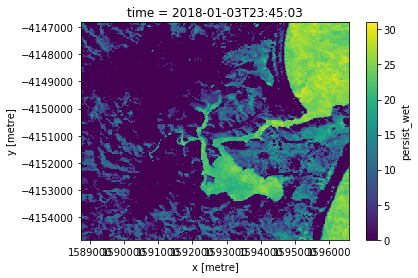

In [27]:
wet_TCI.persist_wet.plot()

In [28]:
#wofs_water

In [29]:
# wet_TCI

In [30]:
#save some tassled cap to file
TCT_once = TCI.isel(time=2)
TCT_once

<xarray.Dataset>
Dimensions:                 (x: 313, y: 320)
Coordinates:
    time                    datetime64[ns] 2018-01-19T23:44:55
  * y                       (y) float64 -4.147e+06 -4.147e+06 ... -4.155e+06
  * x                       (x) float64 1.589e+06 1.589e+06 ... 1.597e+06
Data variables:
    greenness               (y, x) float64 2.015e+03 1.613e+03 ... -106.2 -106.1
    greenness_thresholded   (y, x) float64 2.015e+03 1.613e+03 ... nan nan
    brightness              (y, x) float64 2.459e+03 2.27e+03 ... 295.5 296.2
    brightness_thresholded  (y, x) float64 nan nan nan nan ... nan nan nan nan
    wetness                 (y, x) float64 -416.3 -543.0 -509.8 ... 57.52 56.58
    wetness_thresholded     (y, x) float64 -416.3 -543.0 -509.8 ... 57.52 56.58
Attributes:
    crs:      EPSG: 3577

In [31]:
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
#write_geotiff('/g/data/u46/users/ck9738/Datasets/Tasselled_cap_tifs/Pambula_allTCbands_20180119.tif',TCT_once)